In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate 

import sympy

import surfinBH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing surfinBH

In [2]:
#Pick the fit
fitOpt = list(surfinBH.fits_collection.keys())
print(fitOpt)

[surfinBH.fits_collection[fit].desc for fit in fitOpt]

['NRSur3dq8Remnant', 'surfinBH7dq2', 'NRSur7dq4Remnant']


['Fits for remnant mass, spin and kick veclocity for nonprecessing BBH systems. This model was called surfinBH3dq8 in the paper.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems up to mass ratio 4.']

In [3]:
fit = surfinBH.LoadFits('NRSur7dq4Remnant')
help(fit)

Loaded NRSur7dq4Remnant fit.
Help on Fit7dq4 in module surfinBH._fit_evaluators.fit_7dq4 object:

class Fit7dq4(surfinBH.surfinBH.SurFinBH)
 |  Fit7dq4(name, load_nrsur=False)
 |  
 |  A class for the NRSur7dq4Remnant model presented in Varma et al.,
 |  arxiv:1905.09300, hereafter referred to as THE PAPER.
 |  
 |  This model predicts the final mass mf, final spin vector
 |  chif and final kick velocity vector vf, for the remnants of precessing
 |  binary black hole systems.  The fits are done using Gaussian Process
 |  Regression (GPR) and also provide an error estimate along with the fit
 |  value.
 |  
 |  This model has been trained in the parameter space:
 |      q <= 4, |chiA| <= 0.8, |chiB| <= 0.8
 |  
 |  However, it extrapolates reasonably to:
 |      q <= 6, |chiA| <= 1, |chiB| <= 1
 |  
 |  =========================================================================
 |  Usage:
 |  
 |  import surfinBH
 |  
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur7dq4Remnant')
 |  

In [148]:
fit = surfinBH.LoadFits('NRSur3dq8Remnant')
help(fit)

Loaded NRSur3dq8Remnant fit.
Help on Fit3dq8 in module surfinBH._fit_evaluators.fit_3dq8 object:

class Fit3dq8(surfinBH.surfinBH.SurFinBH)
 |  Fit3dq8(name)
 |  
 |  A class for the NRSur3dq8Remnant model presented in Varma et al.,
 |  arxiv:1809.09125. This model is referred to as surfinBH3dq8 in the paper.
 |  
 |  This model predicts the final mass mf, final
 |  spin chif and final kick velocity vf, for the remnants of nonprecessing
 |  binary black hole systems. The fits are done using Gaussian Process
 |  Regression (GPR) and also provide an error estimate along with the fit
 |  value.
 |  
 |  This model has been trained in the parameter space:
 |      q <= 8, |chiAz| <= 0.8, |chiBz| <= 0.8
 |  
 |  However, it extrapolates reasonably to:
 |      q <= 10, |chiAz| <= 1, |chiBz| <= 1
 |  
 |  =========================================================================
 |  Usage:
 |  
 |  import surfinBH
 |  
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur3dq8Remnant')
 |  
 |  

In [4]:
q = 1
chiA = [0.8,0,0]
chiB = [0.8,0,0]
mf,chif,vf,_,_,_ = fit.all(1,chiA,chiB)
print(f'Final Mass: {mf}')
print(f'Final Spin: {chif}')
print(f'Final Velocity: {vf}')

Final Mass: 0.9497928379066933
Final Spin: [0.28586015 0.04535385 0.70762916]
Final Velocity: [-9.39668527e-05 -2.12472083e-05 -2.87053238e-05]


In [5]:
np.sort([1,2,5,3])[::-1]

array([5, 3, 2, 1])

## Turning a PDF into an easy to sample random variable transform
#### Inverse transform sampling

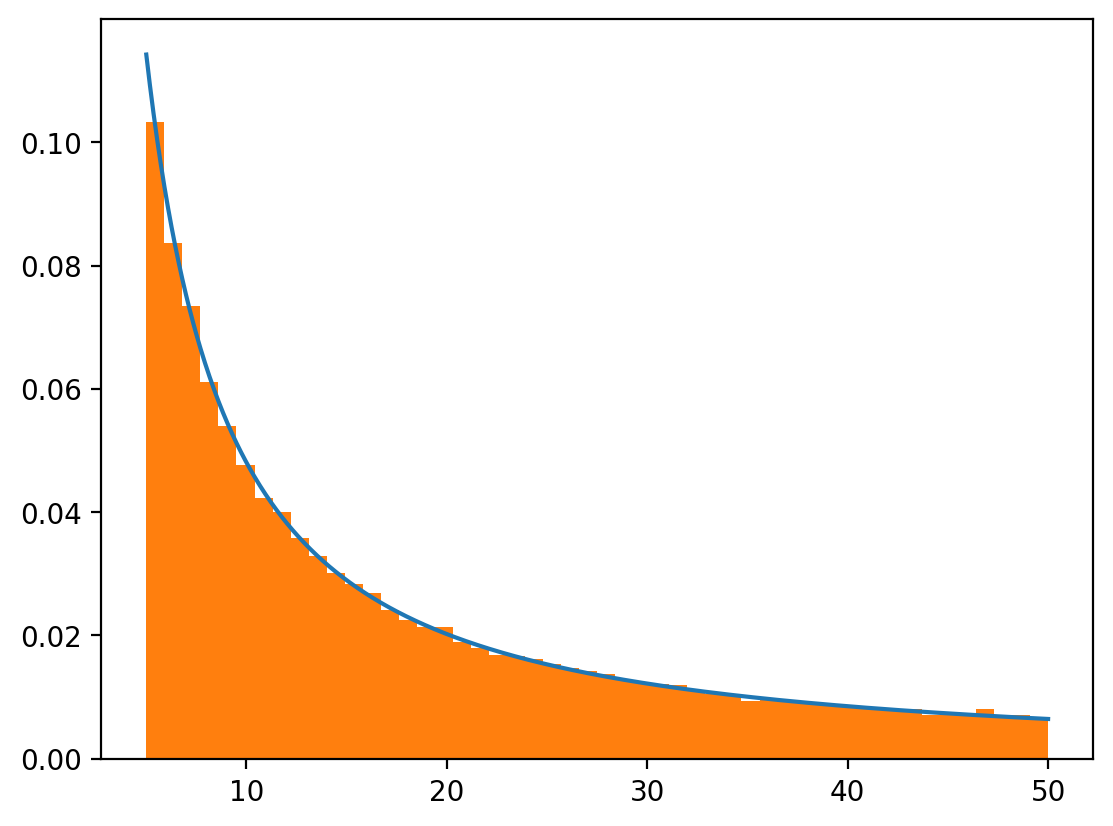

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import sympy

m = sympy.Symbol('m')
p = sympy.Symbol('p')
func = m**(-1.25)
norm = sympy.integrate(func, (m, 5, 50))
pdf = (1/norm)*m**(-1.25)


cdf = sympy.integrate(pdf,(m,5,m))

quantile = sympy.solvers.solve(cdf-p,m)

pdf = sympy.lambdify(m,pdf)
cdf = sympy.lambdify(m,cdf)
quantile = sympy.lambdify(p,quantile)

plt.plot(np.linspace(5,50,1000),pdf(np.linspace(5,50,1000)))

u = np.random.random(100000)
mdist = quantile(u)
plt.hist(mdist,bins=50,density=True)
plt.show()

In [6]:
m = sympy.Symbol('m',positive=True)
p = sympy.Symbol('p',positive=True)

func = m**(-(1.35))

norm = sympy.integrate(func, (m, 5, 50))
        
pdf = (1/norm)*m**(-(1.35))

cdf = sympy.integrate(pdf,(m,5,m))

        
quantile = sympy.solve(cdf-p,m)
try:
    quantile = sympy.lambdify(p,quantile[0])
except:
    quantile = sympy.lambdify(p,quantile)
print(quantile(0.01))

5.079896318680909


## Black hole object making!

In [8]:
import sys
sys.path.append('.')
from BBH_kick_sim import Simulator

In [9]:
params = {'cluster_mass':1e6,'imf_alpha':2.25,'radius':0.5,'rand_spin_type':'zero'}
test = Simulator.Simulator(params,print_missing=True)

'min_bh_star' not set, defaulting to 10
'bh_mass_frac' not set, defaulting to 0.5
'min_star' not set, defaulting to 0.8
'max_star' not set, defaulting to 100
'vel_thresh' not set, defaulting to 0.1
Setting up analytic mass distribution. This may take a while depending on your imf alpha
Done
Loaded NRSur7dq4Remnant fit.
Loaded NRSur3dq8Remnant fit.
Setup complete, Globular Cluster now has 14321 black holes.


In [10]:
test.GC.v_esc

131.53759421116825

In [11]:
test.begin_sim()

No stop time specified, Running until 1 or 0 black holes remain
14321/14321 remaining
12976/14321 remaining
11654/14321 remaining
10348/14321 remaining
9024/14321 remaining
7744/14321 remaining
6470/14321 remaining
5215/14321 remaining
3968/14321 remaining


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=6.709065836521074
Large mass ratio encountered: q=8.808849707902594
Large mass ratio encountered: q=6.7507165972753524


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=9.579016564114461
Large mass ratio encountered: q=6.076604722095099


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=8.26294009691878
Large mass ratio encountered: q=6.369215601224706
Large mass ratio encountered: q=6.241182827708479


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=8.33144791851239
Large mass ratio encountered: q=6.328601474418802
Large mass ratio encountered: q=6.04816545111891
Large mass ratio encountered: q=8.549936856170369
Large mass ratio encountered: q=6.730748338105655
Large mass ratio encountered: q=9.420866294238818


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.068946749313116
Large mass ratio encountered: q=8.041107919473687
Large mass ratio encountered: q=7.572264760603111
Large mass ratio encountered: q=8.401248791081631
Large mass ratio encountered: q=6.328431410174971
Large mass ratio encountered: q=7.365408317362376
Large mass ratio encountered: q=6.038039928549702
Large mass ratio encountered: q=9.263748941655347


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=6.7439421294445845
Large mass ratio encountered: q=7.5868023209488635
Large mass ratio encountered: q=7.167713247106753
Large mass ratio encountered: q=6.544691183069988
Large mass ratio encountered: q=6.62941938975221
Large mass ratio encountered: q=7.671036624258851


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.1753526505196215
Large mass ratio encountered: q=6.372140540727042
Large mass ratio encountered: q=6.220198704040855


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.10606368839103
Large mass ratio encountered: q=6.501035826055903
Large mass ratio encountered: q=7.899910121371481
Large mass ratio encountered: q=6.772701890611615


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.34188536964846
Large mass ratio encountered: q=9.882573482825043


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=7.198454763866024
2257/14321 remaining


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=8.3630357176294


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=7.43819000727867


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.829503245017121
Large mass ratio encountered: q=6.0969061578554
Large mass ratio encountered: q=6.186421889239641
Large mass ratio encountered: q=7.632770524116329
Large mass ratio encountered: q=7.624349826940126
Large mass ratio encountered: q=6.051380935495829


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.681060375340735


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=7.881148950975531
Large mass ratio encountered: q=6.204770715912711
Large mass ratio encountered: q=7.084605102450424
Large mass ratio encountered: q=6.691158974708129


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=6.422764242165972


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=6.620174397303508
Large mass ratio encountered: q=9.170281756920748


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=7.948718795284179
Large mass ratio encountered: q=7.872072674499448
Large mass ratio encountered: q=6.1479817483150745
Large mass ratio encountered: q=8.166205659067316


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=8.88068688872028
Large mass ratio encountered: q=6.142824121118389
Large mass ratio encountered: q=6.608033043574224
Large mass ratio encountered: q=7.769352327316238


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=6.7507618093329
Large mass ratio encountered: q=7.328124916724614
Large mass ratio encountered: q=6.015228926414085


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.159449699241941
Large mass ratio encountered: q=7.366700906386101


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=6.2722346552953345
Large mass ratio encountered: q=6.927023590485169


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=7.979842747482393
Large mass ratio encountered: q=7.337136364724501
Large mass ratio encountered: q=6.551664415201705
Large mass ratio encountered: q=7.457229013375282


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=7.760544488262242
Large mass ratio encountered: q=7.425514899833915
Large mass ratio encountered: q=7.350083527199165
Large mass ratio encountered: q=7.556210443428502
Large mass ratio encountered: q=6.981648393170821


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=7.084495568268943
Large mass ratio encountered: q=6.315880510063949
Large mass ratio encountered: q=6.902439459868999


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.031429068960062
258/14321 remaining
Large mass ratio encountered: q=8.143467086382534
Large mass ratio encountered: q=6.53787242578558
Large mass ratio encountered: q=6.747124849543641


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


Large mass ratio encountered: q=6.140579867278887
Large mass ratio encountered: q=6.511552846310292


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training

Large mass ratio encountered: q=6.593494573740845
Large mass ratio encountered: q=6.461683595969884
Finished. Total Simulation time: 75.99424082690639
Total CPU time: 61.2681679725647


/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')
/Users/gersbaka/opt/anaconda3/envs/astro8020/lib/python3.10/site-packages/surfinBH/surfinBH.py:197: UserWarning: Mass ratio outside training range.
  warnings.warn('Mass ratio outside training range.')


In [12]:
print(len(test.GC.BHs),'in system, ejected:',len(test.GC.ejected))
allBHs = test.GC.BHs + test.GC.ejected
print(len(allBHs))

0 in system, ejected: 4192
4192


In [13]:
if len(test.GC.BHs)>0:
    print(test.GC.BHs[0])
else:
    print(test.GC.ejected[-1])

[M:79.482,S_mag:0.586,v_mag:190.948,v_imag:190.948,t:75.994,t_i:75.994,n_parents:6]


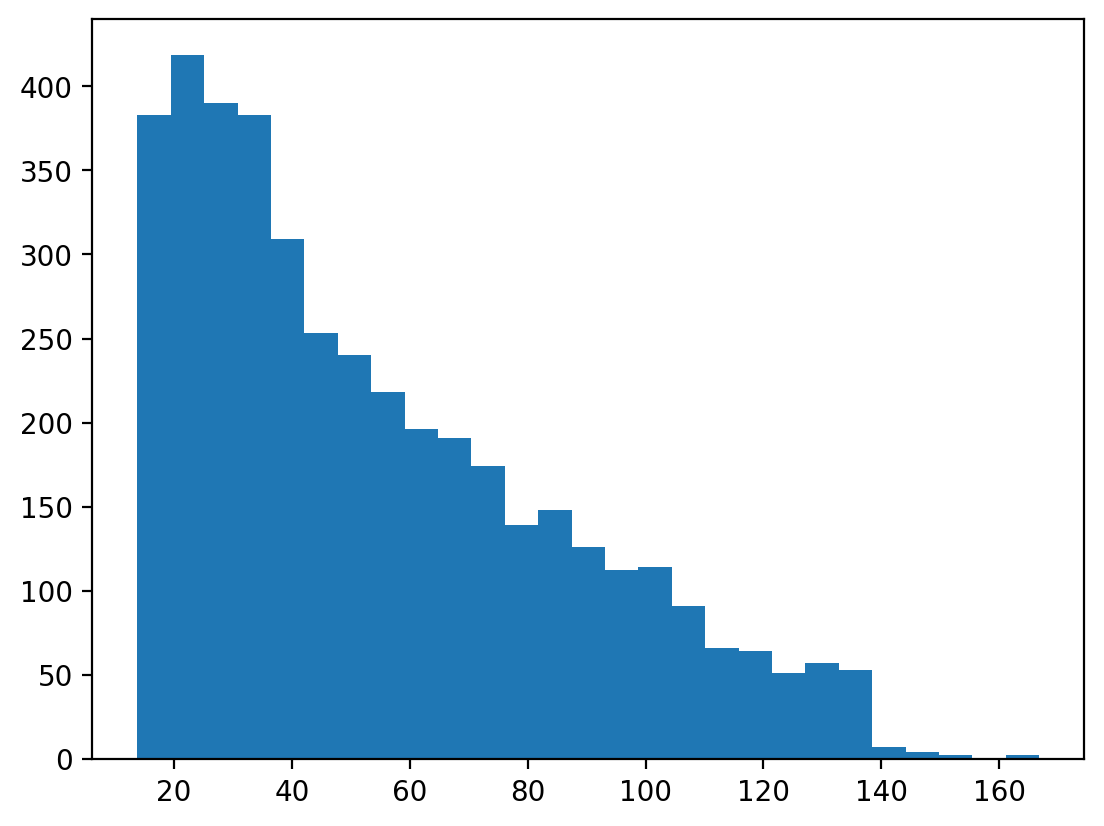

In [14]:
mall = [bh.m for bh in allBHs]
plt.hist(mall,bins='auto')
plt.show()

In [227]:
maxi = np.argmax(mall)
print(allBHs[maxi].m)
print(allBHs[maxi].parents[0].m)
print(allBHs[maxi].parents[1].m)

171.44758436239005
90.27894202338219
92.79684014906678
